# 2次元キャビティ

2次元の側溝の中の流れ。詳細は「偏微分方程式の差分解法」高見・河村 (1994)を参照のこと。

## 支配方程式

2次元非圧縮性流体に対する定常状態の支配方程式は、流線関数 $\phi$、渦度 $\zeta$ を用いて、
$$
  \triangle \phi = -\zeta \\
  \frac{\partial \left( \phi, \zeta \right)}{\partial \left( x, y \right)} + \frac{1}{Re} \triangle \zeta = 0
$$
とかける。但し、
$$
  \frac{\partial \phi}{\partial x} = -v, \frac{\partial \phi}{\partial y} = u, \\
  \zeta = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y} \\
  \frac{\partial \left( \phi, \zeta \right)}{\partial \left( x, y \right)} = \frac{\partial \phi}{\partial x} \frac{\partial \zeta}{\partial y} - \frac{\partial \phi}{\partial y} \frac{\partial \zeta}{\partial x}
$$
となる。

2次元の溝を考え、境界条件は $u(0,y)=u(x,0)=u(1,y)=0, v(0,y)=v(x,0)=v(1,y)=0$（壁で速度0）、$u(x,1)=1, v(x,1)=0$（解放された面に平行な速度をもつ）とする。初期条件は $\phi=0, \zeta=0$ とする。

## 準備

In [1]:
using PyPlot
using OffsetArrays  # 配列の添え字を自由にする

## 次元

In [2]:
imax = 21
jmax = imax

21

In [3]:
dx = 1.0 / ( imax - 1 )
x = range( 0, (imax-1)*dx, step=dx )
y = range( 0, (jmax-1)*dx, step=dx )

0.0:0.05:1.0

## パラメータ

In [4]:
Re=10
nmax = 500
const1 = 1
const2 = 1
eps = 1.0e-4

0.0001

## 境界条件

In [5]:
function BoundaryCondition!(phi, zeta)
    # 左右の壁
    for j in 1:jmax
        zeta[1,j]    = -2.0 * phi[2,j] / ( dx * dx ) 
        zeta[imax,j] = -2.0 * phi[imax-1,j] / ( dx * dx ) 
    end
    # 上下の壁
    for i in 1:imax
        zeta[i,1]    = -2.0 * phi[i,2] / (dx * dx)
        zeta[i,jmax] = -2.0 * ( phi[i,jmax-1] + dx ) / (dx * dx)
    end
end

BoundaryCondition! (generic function with 1 method)

## 反復法
$$
    \zeta_{i,j} \leftarrow \frac{\zeta_{i+1,j}+\zeta_{i-1,j}+\zeta_{i,j+1}+\zeta_{i,j-1}}{4} + \frac{Re}{16} \left\{ \left( \phi_{i+1,j} - \phi_{i-1,j} \right) \left( \zeta_{i,j+1} - \zeta_{i,j-1} \right) - \left( \phi_{i,j+1} - \phi_{i,j-1} \right) \left( \zeta_{i+1,j} - \zeta_{i-1,j} \right) \right\} \\
    \phi_{i,j} \leftarrow \frac{1}{4} \left( \phi_{i+1,j} + \phi_{i-1,j} + \phi_{i,j+1} + \phi_{i,j-1} \right) + \frac{dx^2}{4} \zeta_{i,j}
$$

In [6]:
function OneIteration!(phi, zeta)
    # zetaの更新
    zeta_prev = copy(zeta)
    for j in 2:jmax-1
        for i in 2:imax-1
            rhs = ( ( zeta[i+1,j] + zeta[i-1,j] + zeta[i,j+1] + zeta[i,j-1] ) / 4.0
                  + ( ( phi[i+1,j] - phi[i-1,j] ) * ( zeta[i,j+1] - zeta[i,j-1] ) - ( phi[i,j+1] - phi[i,j-1] ) * ( zeta[i+1,j] - zeta[i-1,j] ) ) * Re / 16.0
                  )
            zeta[i,j] = zeta[i,j] * ( 1.0 - const1 ) + rhs * const1
        end
    end

    # zetaの収束判定
    err1 = maximum( abs.( zeta - zeta_prev ) ./ max.(1.0e-8, abs.(zeta_prev) ) )
    
    # phiの更新
    phi_prev = copy(phi)
    for j in 2:jmax-1
        for i in 2:imax-1
            rhs = ( ( phi[i+1,j] + phi[i-1,j] + phi[i,j+1] + phi[i,j-1] ) / 4.0
                  + zeta[i,j] * dx * dx / 4.0
                  )
            phi[i,j] = phi[i,j] * ( 1.0 - const2 ) + rhs * const2
        end
    end
    
    # phiの収束判定
    err2 = maximum( abs.( phi - phi_prev ) ./ max.(1.0e-8, abs.(phi_prev) ) )
    
    return max( err1, err2 )
end

OneIteration! (generic function with 1 method)

## 初期条件

In [7]:
phi  = zeros(Float64,imax,jmax)
zeta = zeros(Float64,imax,jmax)

21×21 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

## 実行

In [8]:
for n in 1:nmax
    BoundaryCondition!(phi, zeta)
    
    err = OneIteration!(phi, zeta)
    
    if err < eps
        println( "Converge at n=", n )
        break
    end
    if n == nmax
        println( "Do not converge!" )
    end
end

Converge at n=316


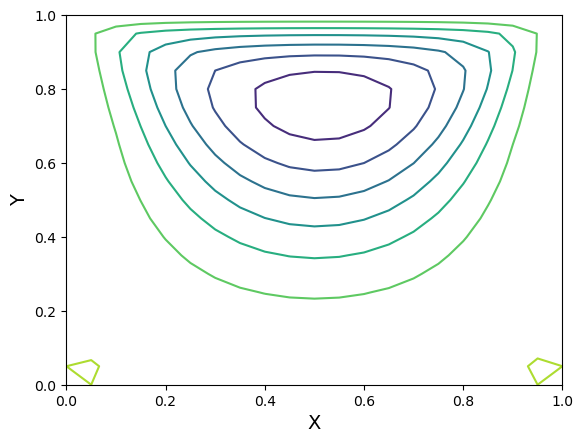

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\thisi\.julia\packages\PyCall\L0fLP\src\numpy.jl:67


PyObject Text(29.000000000000007, 0.5, 'Y')

In [9]:
# plot( x, y, phi )
# contourはv(y,x)という配列を前提にしているため、phiの転置を取る必要がある
cont = contour( x, y, phi' )
xlabel( "X", fontsize=14 )
ylabel( "Y", fontsize=14 )